In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

device

'cuda'

In [3]:
train_df = pd.read_parquet("data/processed_data/train.parquet")
valid_df = pd.read_parquet("data/processed_data/dev.parquet")
test_df = pd.read_parquet("data/processed_data/test.parquet")
display(train_df)
display(valid_df)
display(test_df)

,family_id,sequence_name,family_accession,aligned_sequence,sequence
index,,,,,
8,Trigger_N,F2I568_AERUA/1-145,PF05697.13,MSVKFEETAT...N.EGVLHFTVSKEDAQKA....LKQAYNRVKG....,MSVKFEETATNEGVLHFTVSKEDAQKALKQAYNRVKGKVNIPGFRK...
43,PCRF,D5ANC6_RHOCB/10-198,PF03462.18,ITARFEFLEAKL....NTAL......P.PAEIATL...SREY..SD...,ITARFEFLEAKLNTALPPAEIATLSREYSDLRPVVTEIAAYRQSLD...
68,IPPT,MIAA_ONYPE/37-265,PF01715.17,QMYQKYDIGTAKITL......EEA.....QGI.........K.......,QMYQKYDIGTAKITLEEAQGIKHHLLDFLAPGTNYSIYHFQKDARK...
71,HTH_1,Q9F2K8_STRCO/4-63,PF00126.27,VRHLECFVAVAEES.HFGRAAT.RLGM...AQPPLSQRIQRLEK.E...,VRHLECFVAVAEESHFGRAATRLGMAQPPLSQRIQRLEKELGVRLF...
99,Methyltransf_25,Q2S1D8_SALRD/44-141,PF13649.6,ILDIGCGR.G...R..HA...RA..LV.RR.......G...........,ILDIGCGRGRHARALVRRGWQVTGLDLSEDAVAAARSRVADDDLDV...
...,...,...,...,...,...
13278,His_kinase,D2PX86_KRIFD/171-249,PF06580.13,AE.L..RALRAQISPHFIYNALAAI......A....SF...V.......,AELRALRAQISPHFIYNALAAIASFVRTDPERARELLLEFADFSRY...
13287,Glycos_trans_3N,D7BI04_MEISD/4-63,PF02885.17,...LKKALHA.....E.PLTQDEAHRLMSRI..MS.GD...........,LKKALHAEPLTQDEAHRLMSRIMSGDLTPAQTAGVLIALRTRGETL...
13304,MutS_III,MSH3_MOUSE/498-793,PF05192.18,TTLRNLEM.VQ................NQTDM.................,TTLRNLEMVQNQTDMKTKGSLLWVLDHTKTSFGRRKLKNWVTQPLL...


,family_id,sequence_name,family_accession,aligned_sequence,sequence
index,,,,,
29,BacA,UPPP_OCHA4/9-259,PF02673.18,AAFLGLIEGLTEFIPVSSTGHL..LLIGHF.L....GFES.........,AAFLGLIEGLTEFIPVSSTGHLLLIGHFLGFESTGKTFEVLIQLGA...
37,DNA_binding_1,R7XUX1_9ACTN/76-156,PF01035.20,AFQQRV.WEQ.LRL..IPYGETASYGEIA................G...,AFQQRVWEQLRLIPYGETASYGEIAGRLGMTNAASRAVGLANGRNP...
43,PCRF,RF1_BACAN/8-202,PF03462.18,VENRYEKLNELL....SDPAII.S..D.SNKLREY...SKEQ..SD...,VENRYEKLNELLSDPAIISDSNKLREYSKEQSDIQETVEVYREYKD...
61,Lipase_GDSL_2,G0RZP4_CHATD/19-209,PF13472.6,CFGDS.LTA.......GYCSM............................,CFGDSLTAGYCSMGAMFHPYHERLEQMLAMAFPDIAFETVEDGVPG...
72,gag_pre-integrs,Q8TFK0_DEBHN/195-267,PF13976.6,NNKYI..KI..........S....N.M...N.H...........E....,NNKYIKISNMNHEIANPFKRKRDLMYYHLMGNHMSLESMKYLIKSG...
...,...,...,...,...,...
12724,Ala_racemase_C,R6NDI3_9CLOT/243-369,PF00842.21,ALSWHARISHIKTL.EAGR.E..ISYGGTF.TTVK.P.TVVATVPV...,ALSWHARISHIKTLEAGREISYGGTFTTVKPTVVATVPVGYADGYP...
12727,THF_DHG_CYH,B2ATS2_PODAN/22-135,PF00763.23,VILADTIAK...K........MLA.EVQ...STL...............,VILADTIAKKMLAEVQSTLSAIQLPRRPTLSAFLANDDPHAYQYAE...
12728,Ig_3,A8X5T7_CAEBR/262-333,PF13927.6,KPIVF......VTPTENLTH...LSVEEGE.LVN....L.TC..NA...,KPIVFVTPTENLTHLSVEEGELVNLTCNAAANPPAHSYEWKHISSG...


,family_id,sequence_name,family_accession,aligned_sequence,sequence
index,,,,,
1,DnaJ_C,M4V8X0_9PROT/126-339,PF01556.18,LRFITEIELEEVISG.K.E.....AQI......EF..............,LRFITEIELEEVISGKEAQIEFDTEANCDDCNGSGAAKGSSATTCP...
9,TrmE_N,B0X5R4_CULQU/21-138,PF10396.9,TIFGLSS..G..S..G.K..C.G..VAVIRVSG................,TIFGLSSGSGKCGVAVIRVSGDASSDVVHRKTSSNKLPAARQAVLR...
16,Lipase_GDSL_2,H6MZH3_GORPV/43-278,PF13472.6,ALGDS.RAS.......GNMPGLQ......................P...,ALGDSRASGNMPGLQPSDGCWRSSTSYPSVLARIAHVRSFVDRSCA...
26,UPF0051,Q7UKR5_RHOBA/213-439,PF01458.17,GQFERT.....L.I.....IVDEG.....ASI..HYV............,GQFERTLIIVDEGASIHYVEGCTAPMYTTESLHSAVVEVIVKKDAR...
56,THF_DHG_CYH,S3CNX4_OPHP1/11-126,PF00763.23,.ILADSIGK...N........MLV.EVQ...ESR...............,ILADSIGKNMLVEVQESRDAFRKEHGIERKLCLAAFLANDDPHAVK...
...,...,...,...,...,...
12706,Chromate_transp,F2F022_SOLSS/4-171,PF02417.15,WELFIAFLIPNLLAYGGGPASI.PLIEHEV........VD.........,WELFIAFLIPNLLAYGGGPASIPLIEHEVVDRYEWMTQSEFSEFLA...
12708,E3_binding,A8LBI7_FRASN/171-205,PF02817.17,.VISPLVR.RLARDNAV....DLR..EL..T....G....T.GPDG...,VISPLVRRLARDNAVDLRELTGTGPDGLIRRRDVE-----------...
12730,THF_DHG_CYH,C6WZR6_FLAB3/4-120,PF00763.23,ILDGLKVSK...E........IKN.EIR...TDV...............,ILDGLKVSKEIKNEIRTDVEKIVEGKRRPPHLVAILVGQNGASISY...


In [4]:
alphabet = list("ACDEFGHIKLMNPQRSTVWY") + ["-"]
alphabet

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 '-']

In [5]:
MAX_SEQ_LEN = train_df["sequence"].str.len().max()
N_CLASSES = len(train_df["family_accession"].unique())
VOCAB_SIZE = len(alphabet)
print(MAX_SEQ_LEN, N_CLASSES, VOCAB_SIZE)

256 64 21


In [6]:
le = LabelEncoder()
y_train = train_df["family_accession"].to_numpy()
y_train = le.fit_transform(y_train)
y_valid = le.transform(valid_df["family_accession"].to_numpy())
y_test = le.transform(test_df["family_accession"].to_numpy())

display(y_train, y_valid, y_test)

array([51, 45, 26, ..., 50, 42, 58], shape=(66226,))

array([34, 14, 45, ..., 60, 51, 12], shape=(8249,))

array([24, 54, 56, ..., 12,  7, 59], shape=(8242,))

In [7]:
def make_features(df):
    # iloc remove start/end padding of ""
    X = df["sequence"].str.split("", expand=True).iloc[:, 1:-1].to_numpy()
    return X


make_features(train_df)

array([['M', 'S', 'V', ..., '-', '-', '-'],
       ['I', 'T', 'A', ..., '-', '-', '-'],
       ['Q', 'M', 'Y', ..., '-', '-', '-'],
       ...,
       ['T', 'T', 'L', ..., 'R', 'E', 'Q'],
       ['A', 'E', 'F', ..., '-', '-', '-'],
       ['V', 'V', 'D', ..., '-', '-', '-']],
      shape=(66226, 256), dtype=object)

In [8]:
oe = OrdinalEncoder(categories=[alphabet] * MAX_SEQ_LEN)
X_train = oe.fit_transform(make_features(train_df))
X_valid = oe.transform(make_features(valid_df))
X_test = oe.transform(make_features(test_df))
display(X_train, X_valid, X_test)

array([[10., 15., 17., ..., 20., 20., 20.],
       [ 7., 16.,  0., ..., 20., 20., 20.],
       [13., 10., 19., ..., 20., 20., 20.],
       ...,
       [16., 16.,  9., ..., 14.,  3., 13.],
       [ 0.,  3.,  4., ..., 20., 20., 20.],
       [17., 17.,  2., ..., 20., 20., 20.]], shape=(66226, 256))

array([[ 0.,  0.,  4., ..., 20., 20., 20.],
       [ 0.,  4., 13., ..., 20., 20., 20.],
       [17.,  3., 11., ..., 20., 20., 20.],
       ...,
       [ 8., 12.,  7., ..., 20., 20., 20.],
       [10.,  8.,  7., ..., 20., 20., 20.],
       [ 9.,  9.,  2., ..., 20., 20., 20.]], shape=(8249, 256))

array([[ 9., 14.,  4., ..., 20., 20., 20.],
       [16.,  7.,  4., ..., 20., 20., 20.],
       [ 0.,  9.,  5., ..., 20., 20., 20.],
       ...,
       [ 7.,  9.,  2., ..., 20., 20., 20.],
       [ 2., 16., 17., ..., 20., 20., 20.],
       [ 8., 11., 14., ..., 20., 20., 20.]], shape=(8242, 256))

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
y_pred_test = knn.predict(X_test)

metrics = [
    (accuracy_score, {}),
    (balanced_accuracy_score, {}),
    (f1_score, {"average": "weighted"}),
]

print("Validation set")
for metric, kwargs in metrics:
    print(f"{metric.__name__}: {metric(y_valid, y_pred, **kwargs):.3f}")

print("Test set")
for metric, kwargs in metrics:
    print(f"{metric.__name__}: {metric(y_test, y_pred_test, **kwargs):.3f}")

Validation set
accuracy_score: 0.931
balanced_accuracy_score: 0.929
f1_score: 0.929
Test set
accuracy_score: 0.925
balanced_accuracy_score: 0.922
f1_score: 0.924


In [11]:
for average in ["micro", "macro", "weighted"]:
    score = f1_score(y_valid, y_pred, average=average)
    print(f"{average} f1-score {score:.3f}")

micro f1-score 0.931
macro f1-score 0.929
weighted f1-score 0.929


In [27]:
X_train = torch.tensor(X_train, dtype=torch.long)
X_valid = torch.tensor(X_valid, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

/tmp/ipykernel_1317206/2106405653.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long)
/tmp/ipykernel_1317206/2106405653.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid = torch.tensor(X_valid, dtype=torch.long)
/tmp/ipykernel_1317206/2106405653.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_1317206/2106405653.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clo

In [32]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
train_set = TensorDataset(X_train, y_train)
dataloader = DataLoader(train_set, batch_size=128, shuffle=True)

In [73]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.LayerNorm(input_size),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, out_size),
        )
        self.cls_head = nn.Softmax(dim=1)

    def forward(self, x, y=None):
        logits = self.fc(x)

        loss = None
        preds = None
        probs = None
        if y is not None:
            loss = F.cross_entropy(logits, y.view(-1))
            probs = self.cls_head(logits)
            preds = probs.argmax(dim=1)

        return logits, loss, preds, probs


model = MLPClassifier(input_size=MAX_SEQ_LEN, hidden_size=128, out_size=N_CLASSES).to(
    device
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epochs = 20
loss_histories = defaultdict(list)
acc_histories = defaultdict(list)

for epoch in range(n_epochs):
    train_loss = 0
    y_train_pred = []
    for step, batch in enumerate(dataloader):
        xb, yb = batch
        xb = xb.to(device)
        yb = yb.to(device)
        logits, loss, preds, probs = model(xb.float(), yb)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = 0.0  # TODO:
    train_loss /= len(dataloader.dataset)

    loss_histories["train"].append(train_loss)

    model.eval()
    val_logits, val_loss, y_pred, _ = model(X_valid.float(), y_valid)
    loss_histories["valid"].append(val_loss)

    val_acc = balanced_accuracy_score(y_valid.cpu(), y_pred.cpu())
    acc_histories["valid"].append(val_acc)
    tqdm.write(
        f"Epoch: {epoch}, train loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_acc {train_acc:.4f}, val_acc {val_acc:.4f}"
    )
    model.train()

Epoch: 0, train loss: 0.0211, val_loss: 1.8034, train_acc 0.0000, val_acc 0.5938
Epoch: 1, train loss: 0.0110, val_loss: 1.1258, train_acc 0.0000, val_acc 0.7427
Epoch: 2, train loss: 0.0074, val_loss: 0.8195, train_acc 0.0000, val_acc 0.8024
Epoch: 3, train loss: 0.0056, val_loss: 0.6639, train_acc 0.0000, val_acc 0.8293
Epoch: 4, train loss: 0.0046, val_loss: 0.5721, train_acc 0.0000, val_acc 0.8481
Epoch: 5, train loss: 0.0040, val_loss: 0.5168, train_acc 0.0000, val_acc 0.8627
Epoch: 6, train loss: 0.0036, val_loss: 0.4765, train_acc 0.0000, val_acc 0.8704
Epoch: 7, train loss: 0.0033, val_loss: 0.4496, train_acc 0.0000, val_acc 0.8764
Epoch: 8, train loss: 0.0031, val_loss: 0.4274, train_acc 0.0000, val_acc 0.8826
Epoch: 9, train loss: 0.0029, val_loss: 0.4152, train_acc 0.0000, val_acc 0.8838
Epoch: 10, train loss: 0.0028, val_loss: 0.4007, train_acc 0.0000, val_acc 0.8883
Epoch: 11, train loss: 0.0026, val_loss: 0.3904, train_acc 0.0000, val_acc 0.8871
Epoch: 12, train loss: 0.0

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

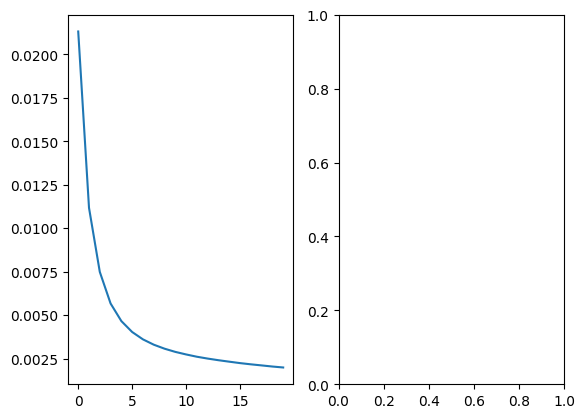

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].plot(loss_histories["train"], label="train")
ax[0].plot(loss_histories["valid"], label="valid")
ax[0].legend()
ax[1].plot(acc_histories["train"], label="train")
ax[1].plot(acc_histories["valid"], label="valid")
ax[1].legend();

In [75]:
class AttentionBlock(nn.Module):
    def __init__(self, n_embed, n_head=4):
        super().__init__()
        self.n_embed = n_embed
        self.n_head = n_head

        self.attn = nn.Linear(
            n_embed, 3 * n_embed
        )  # output keys, queries, values in one contiguous tensor
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.attn(x)
        q, k, v = qkv.chunk(3, dim=2)

        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        out = F.scaled_dot_product_attention(q, k, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, out_size):
        # input_size - seq len
        # -> should be vocab size
        # hidden_size - embedding dimension
        # out_size - n_classes
        super().__init__()
        self.input_size = input_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.emb = nn.Embedding(vocab_size, hidden_size)
        self.pos = nn.Embedding(input_size, hidden_size)

        self.attention = AttentionBlock(hidden_size, n_head=4)
        self.ln = nn.LayerNorm(hidden_size)
        self.fc = MLPClassifier(
            input_size=hidden_size, hidden_size=hidden_size, out_size=out_size
        )

        self.register_buffer(
            "pos_idx", torch.arange(input_size, dtype=torch.long), persistent=False
        )

    def forward(self, x, y=None):
        out = self.emb(x) + self.pos(self.pos_idx)

        out = self.attention(out + self.ln(out)).mean(dim=1)

        logits, loss, preds, probs = self.fc(out, y)

        return logits, loss, preds, probs


model = Transformer(
    vocab_size=VOCAB_SIZE,
    input_size=MAX_SEQ_LEN,
    hidden_size=MAX_SEQ_LEN // 2,
    out_size=N_CLASSES,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epochs = 10
loss_histories = defaultdict(list)
acc_histories = defaultdict(list)

X_valid = X_valid.to(device)
y_valid = y_valid.to(device)

for epoch in range(n_epochs):
    train_loss = 0
    for step, batch in enumerate(tqdm(dataloader)):
        xb, yb = batch
        xb = xb.to(device)
        yb = yb.to(device)
        logits, loss, _, _ = model(xb, yb)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss /= len(dataloader)
        loss_histories["train"].append(train_loss)

        val_logits, val_loss, y_pred, _ = model(X_valid, y_valid)
        loss_histories["valid"].append(val_loss)

        val_acc = balanced_accuracy_score(y_valid.cpu(), y_pred.cpu())
        tqdm.write(
            f"Epoch: {epoch}, train loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc {val_acc:.4f}"
        )
    model.train()

  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 0, train loss: 2.2294, val_loss: 1.0935, val_acc 0.8818


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.6723, val_loss: 0.3908, val_acc 0.9600


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.2861, val_loss: 0.2074, val_acc 0.9753


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.1634, val_loss: 0.1302, val_acc 0.9828


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.1079, val_loss: 0.0936, val_acc 0.9864


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.0769, val_loss: 0.0691, val_acc 0.9899


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.0577, val_loss: 0.0562, val_acc 0.9896


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.0446, val_loss: 0.0484, val_acc 0.9918


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.0347, val_loss: 0.0394, val_acc 0.9928


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.0283, val_loss: 0.0363, val_acc 0.9919


In [17]:
from transformers import AutoTokenizer, EsmModel
import math


model_id = "facebook/esm2_t6_8M_UR50D"
# device = "mps"
tok = AutoTokenizer.from_pretrained(model_id, do_lower_case=False)
model = EsmModel.from_pretrained(model_id).to(device)

model.eval()

CLS_TOKEN_ID = tok.cls_token_id


def convert_to_embeddings(df, batch_size=64):
    n_batches = math.ceil(len(df) / batch_size)
    embeddings_list = []
    with torch.no_grad():
        for batch in tqdm(range(n_batches)):
            start = batch * batch_size
            end = min(len(df), (batch + 1) * batch_size)
            batch = tok(list(df["sequence"].iloc[start:end]), return_tensors="pt")

            out = model(**batch.to(device))
            batch_embeddings = out.last_hidden_state[:, CLS_TOKEN_ID, :]
            embeddings_list.append(batch_embeddings.cpu())

    return torch.concat(embeddings_list)


batch_size = 64
train_embeddings = convert_to_embeddings(train_df, batch_size=batch_size)
valid_embeddings = convert_to_embeddings(valid_df, batch_size=batch_size)
test_embeddings = convert_to_embeddings(test_df, batch_size=batch_size)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

In [21]:
print(train_embeddings.shape)
print(valid_embeddings.shape)
print(test_embeddings.shape)

torch.Size([66226, 320])
torch.Size([8249, 320])
torch.Size([8242, 320])


In [21]:
path = "data/esm_embeddings"

torch.save(train_embeddings, f"{path}/train_embeddings.pt")
torch.save(valid_embeddings, f"{path}/valid_embeddings.pt")
torch.save(test_embeddings, f"{path}/test_embeddings.pt")

In [76]:
model = MLPClassifier(
    input_size=train_embeddings.shape[1], hidden_size=128, out_size=N_CLASSES
).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
dataloader = DataLoader(TensorDataset(train_embeddings, y_train), batch_size=128)

epochs = 10
valid_embeddings = valid_embeddings.to(device)
for epoch in range(epochs):
    for step, batch in enumerate(tqdm(dataloader)):
        xb, yb = batch
        xb = xb.to(device)
        yb = yb.to(device)
        logits, loss, preds, probs = model(xb, yb)

        optim.zero_grad()
        loss.backward()
        optim.step()

    with torch.no_grad():
        model.eval()
        val_pred = model(valid_embeddings, y_valid)[2].view(-1)
        val_acc = balanced_accuracy_score(y_valid.cpu(), val_pred.cpu())
        print(f"Epoch {epoch}, val_acc {val_acc:.3f}")
        model.train()

        # print((y_valid.cpu()))
        # print(torch.unique(val_pred.cpu()).intersection(set(y_valid.cpu())))

  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 0, val_acc 0.872


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 1, val_acc 0.957


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 2, val_acc 0.975


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 3, val_acc 0.983


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 4, val_acc 0.987


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 5, val_acc 0.989


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 6, val_acc 0.990


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 7, val_acc 0.990


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 8, val_acc 0.990


  0%|          | 0/518 [00:00<?, ?it/s]

Epoch 9, val_acc 0.991
